参考：https://brian2.readthedocs.io/en/stable/examples/frompapers.Stimberg_et_al_2018.example_1_COBA.html

In [1]:
from brian2 import *
import sympy
seed(134354) # to get identical figures for repeated runs

In [2]:
### General parameters
duration = 60.0*second  # Total simulation time
N_e = 1600             # Number of excitatory neurons
N_i = 400              # Number of inhibitory neurons
I_ex = 100*pA          # External current
stimulus = TimedArray([1.0] * 60, dt=1*second) # 100 pA 単位
exc_syn_prop = 0.05    # Proportion of excitatory synapses that are connected
inh_syn_prop = 0.20    # Proportion of inhibitory synapses that are connected

In [3]:
################################################################################
# Model parameters
################################################################################

### Neuron parameters
E_l = -60*mV           # Leak reversal potential
g_l = 9.99*nS          # Leak conductance
E_e = 0*mV             # Excitatory synaptic reversal potential
E_i = -80*mV           # Inhibitory synaptic reversal potential
C_m = 198*pF           # Membrane capacitance
tau_e = 5*ms           # Excitatory synaptic time constant
tau_i = 10*ms          # Inhibitory synaptic time constant
tau_r = 5*ms           # Refractory period
V_th = -50*mV          # Firing threshold
V_r = E_l              # Reset potential

### Synapse parameters
w_e = 0.05*nS          # Excitatory synaptic conductance
w_i = 1.0*nS           # Inhibitory synaptic conductance
U_0 = 0.6              # Synaptic release probability at rest
Omega_d = 2.0/second   # Synaptic depression rate
Omega_f = 3.33/second  # Synaptic facilitation rate

In [4]:
################################################################################
# Model definition
###############################################################################

### Neurons
neuron_eqs = '''
dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) + I_ex*stimulus(t))/C_m    : volt (unless refractory)
dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
dg_i/dt = -g_i/tau_i  : siemens  # post-synaptic inh. conductance
'''
neurons = NeuronGroup(N_e + N_i, model=neuron_eqs,
                      threshold='v>V_th', reset='v=V_r',
                      refractory='tau_r', method='euler')
# Random initial membrane potential values and conductances
neurons.v = 'E_l + rand()*(V_th-E_l)'
neurons.g_e = 'rand()*w_e'
neurons.g_i = 'rand()*w_i'
exc_neurons = neurons[:N_e]
inh_neurons = neurons[N_e:]

### Synapses
synapses_eqs = '''
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S     : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
'''
synapses_action = '''
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
'''
exc_syn = Synapses(exc_neurons, neurons, model=synapses_eqs, on_pre=synapses_action+'g_e_post += w_e*r_S')
inh_syn = Synapses(inh_neurons, neurons, model=synapses_eqs, on_pre=synapses_action+'g_i_post += w_i*r_S')

exc_syn.connect(p=exc_syn_prop)
inh_syn.connect(p=inh_syn_prop)
# Start from "resting" condition: all synapses have fully-replenished neurotransmitter resources
exc_syn.x_S = 1
inh_syn.x_S = 1

In [5]:
##############################################################################
# Monitors
##############################################################################
# Note that we could use a single monitor for all neurons instead, but in this
# way plotting is a bit easier in the end
exc_mon = SpikeMonitor(exc_neurons)
inh_mon = SpikeMonitor(inh_neurons)

In [6]:
# ##############################################################################
# # Simulation run
# ##############################################################################
run(duration, report='text')

Starting simulation at t=0. s for a duration of 60. s
20.4279 s (34%) simulated in 10s, estimated 19s remaining.
40.7159 s (67%) simulated in 20s, estimated 9s remaining.
60. s (100%) simulated in 29s


[(0, 50.0),
 Text(0, 0.5, 'rate (Hz)'),
 (0.0, 60000.0),
 Text(0.5, 0, 'time (ms)')]

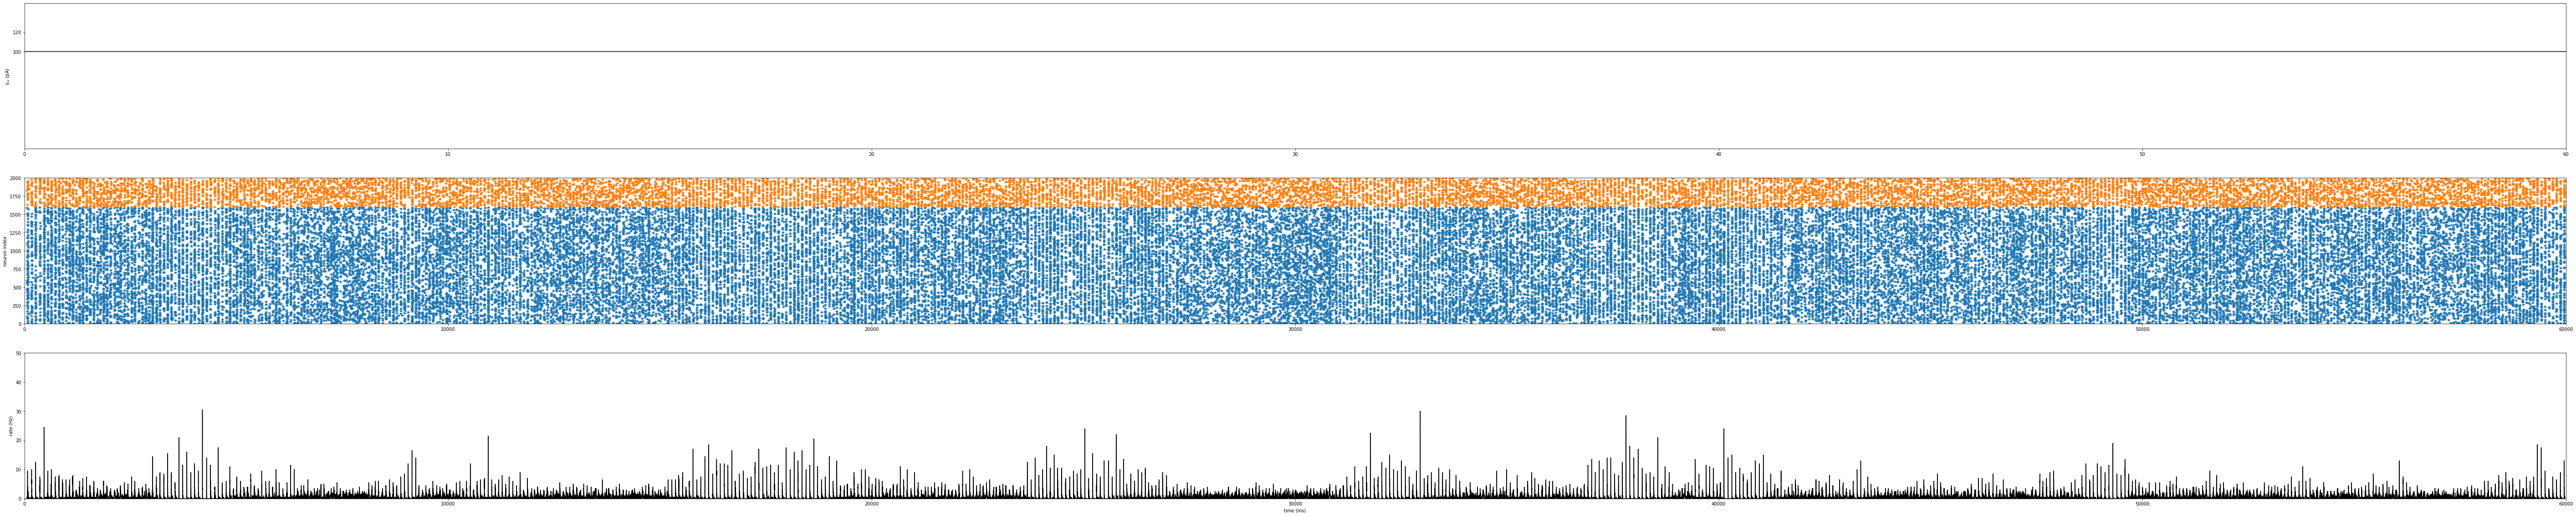

In [7]:
################################################################################
# Analysis and plotting
################################################################################
fig1, ax = plt.subplots(nrows=3, ncols=1, figsize=(100, 20))

# Input current
time_range = np.linspace(0, int(duration/second), int(duration/second)*100)*second
ax[0].plot(time_range, I_ex*stimulus(time_range)/pA, 'k')
ax[0].set(xlim=(0, duration/second), ylim=(0, 150), yticks=[100, 120], ylabel='$I_{ex}$ (pA)')

##Spiking activity (w/ rate)
ax[1].plot(exc_mon.t[exc_mon.i <= N_e]/ms, exc_mon.i[exc_mon.i <= N_e], '*', color='C0')
ax[1].plot(inh_mon.t[inh_mon.i <= N_i]/ms, inh_mon.i[inh_mon.i <= N_i]+N_e, '*', color='C1')
ax[1].set(xlim=(0., duration/ms), ylim=(0, (N_e+N_i)), ylabel='neuron index')

# Generate frequencies
bin_size = 1*ms
spk_count, bin_edges = np.histogram(np.r_[exc_mon.t/ms, inh_mon.t/ms], int(duration/ms))
rate = double(spk_count)/(N_e + N_i)/bin_size/Hz
ax[2].plot(bin_edges[:-1], rate, '-', color='k')
ax[2].set(xlim=(0., duration/ms), ylim=(0, 50.), xlabel='time (ms)', ylabel='rate (Hz)')